In [2]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [3]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 35°C,   0 % |  5551 / 81920 MB | llogan3(3480M) akapoor(510M) akapoor(510M) akapoor(510M) akapoor(510M)
  [1] NVIDIA A100 80GB PCIe | 28°C,   0 % |     3 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 30°C,   0 % |     3 / 81920 MB |
])


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Read in dataset to use for training

In [58]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_dataframe, spatial_sample = True):
        self.labels = labels_dataframe
        self.base_folder = base_folder
        self.spatial_sample = spatial_sample
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        N = row.loc['N']
        n = row.loc['n']
        rep = int(row.loc['rep'])
        group_size = int(row.loc['group_size'])
        if(self.spatial_sample):
            spaghetti_pops_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/pops_{N}_{n}_{rep}.png'
            spaghetti_pops = read_image(spaghetti_pops_path)
            spaghetti_sibs_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/halfsibs_{N}_{n}_{rep}.png'
            spaghetti_sibs = read_image(spaghetti_sibs_path)
            sampling_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/intensity_map_{N}_{n}_{rep}.png'
            intensity_map = read_image(sampling_path)
        else:
            spaghetti_pops_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/random_pops_{N}_{n}_{rep}.png'
            spaghetti_pops = read_image(spaghetti_pops_path)
            spaghetti_sibs_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/random_halfsibs_{N}_{n}_{rep}.png'
            spaghetti_sibs = read_image(spaghetti_sibs_path)
            intensity_map = Image.new("L", (50, 50))
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity_map), 0).float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label, n, group_size

In [65]:
spatial_labels = pd.read_csv("/sietch_colab/gpatters/ckmr/elephants/spatial_labels.csv")
random_labels = pd.read_csv("/sietch_colab/gpatters/ckmr/elephants/random_labels.csv")
kin_dataset = KinDataset("/sietch_colab/gpatters/ckmr/elephants", spatial_labels, spatial_sample = True)

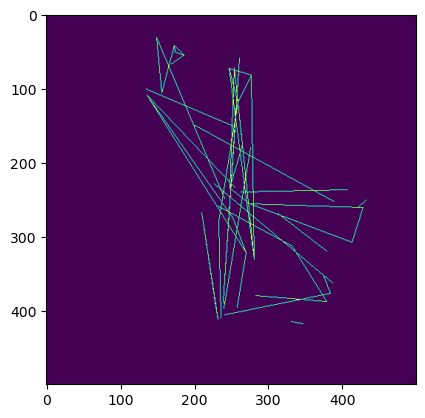

In [66]:
plt.imshow(kin_dataset[2][0][0])
plt.imshow(kin_dataset[2][0][1])
#plt.imshow(kin_dataset[2][0][2])

In [67]:
n_total = len(kin_dataset)
n_train = round(n_total*0.75)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [68]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

14625
2438
2437


In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, padding=3)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [70]:
loss_fn = nn.MSELoss(reduction='mean')

In [73]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch, n, group_size in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch, n, group_size in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [ ]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

In [12]:
#Save model
PATH = "model_elephants.pt"
torch.save(model.state_dict(), PATH)

In [12]:
# Load model
PATH = "model_elephants.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

/tmp/ipykernel_2879332/2064567138.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


Net(
  (conv1): Conv2d(2, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

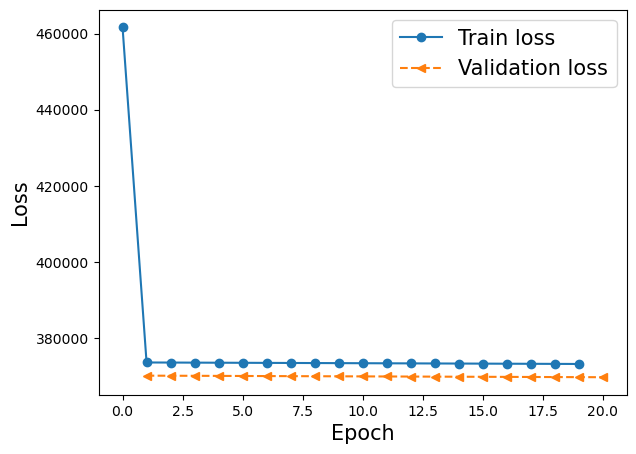

In [13]:
train_x = np.arange(len(hist[0]))-1
val_x = np.arange(len(hist[0]))

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0][1:], '-o', label='Train loss')
ax.plot(val_x, hist[1][1:], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [20]:
test_kin, extra_test_kin = random_split(test_kin, [100, n_test-100], generator=torch.Generator().manual_seed(400))

In [24]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_n = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output, n) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_n[i] = n

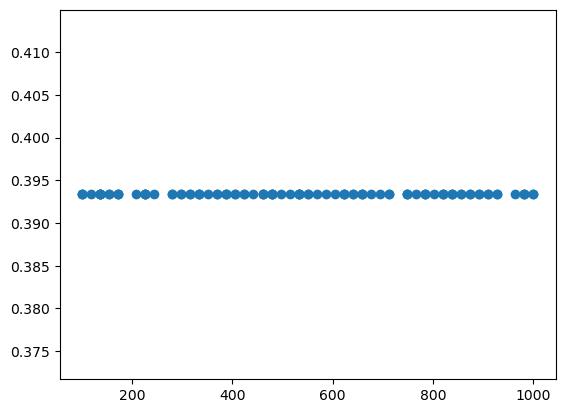

In [26]:
plt.scatter(test_truth, test_pred)
#plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [23]:
# Write test results to file
results = {'N': test_truth, 'pred': test_pred, 'n': n}
df = pd.DataFrame(data=results)
df.to_csv("network_results.csv", index = False)